In [31]:
import pickle
import numpy as np
import pandas as pd
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import os

import seaborn as sb

from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn import preprocessing 
from sklearn.cluster import KMeans

#from mat4py import loadmat
from sklearn.datasets import make_blobs
from matplotlib import style
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from pathlib import Path

## Configuration parameters

In [32]:
#Data folder
data_dir='/home/malvarez/TFG2/Instrumentos/DataInput/Preprocessed/'

#File name with data
filename="df_features"

#Output folder
data_out='/home/malvarez/TFG2/Instrumentos/Models/Features/'
model_folder='/VersionAA/'


## User defined functions

In [33]:
def LoadDataFile(data_dir,filename,typefile):
    '''
    Loads a feature file an returns Xtrain and Ytrain
    '''
    with open(data_dir+filename+'_'+typefile+'.pickle', 'rb') as f:
        df = pickle.load(f)
    
    y = df['targets']
    X = df.drop(labels=['targets'], axis=1)
    
    return [X,y]

In [34]:
def SelectColumns(columns,selected):
    
    '''
    It returns the selected columns in the columns name convention
    '''
    sel_column=[]
    keys=selected.keys()
    for key in keys:
        #print('Testing {}: {}'.format(key,selected[key]))
        if type(selected[key])==bool:
            if selected[key]==True:
                for col in columns:
                    if key == col:
                        sel_column.append(col)
                        break
        if type(selected[key])==list:
            for i in selected[key]:
                #print(i)
                s=key+'_'+str(i) 
                for col in columns:
                     if s == col:
                        sel_column.append(col) 
                        break
    return sel_column

In [35]:
def SelectedFeatures(X,selected):
    '''
    It is used to select the features that will be used in the training
    '''
    sel_column=SelectColumns(X.columns,selected)
    #print(selected)
    #print(sel_column)

    Xsel=X[sel_column]
    
    return [Xsel,sel_column]

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
   
    return ax

## Load  data files

In [37]:
X_train, y_train = LoadDataFile(data_dir,filename,'train')
X_test, y_test = LoadDataFile(data_dir,filename,'test')

In [38]:
print(X_train.shape)
X_train.head(2)

(500, 166)


,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,rolloff_0,zc_0,zcr_0,lpc_0
brass_acoustic_062-041-025,0,-314.112030,231.063126,29.018843,-24.469727,-8.514785,-2.547920,-1.098820,-5.916578,-8.266499,...,22.639154,24.275723,24.875633,21.909768,16.849076,49.651605,1074.544177,0.037302,0.036663,0.006212
flute_acoustic_024-067-025,0,-274.683563,52.423744,-52.399376,20.521128,-5.209689,18.693207,-8.449156,-7.702608,-17.181465,...,36.149397,38.431155,31.493801,24.547661,18.687216,53.117658,1665.151395,0.037710,0.037431,0.007916


In [39]:
print(X_test.shape)
X_test.head(2)

(50, 166)


,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,rolloff_0,zc_0,zcr_0,lpc_0
organ_electronic_057-034-100,0,-424.077026,76.245125,48.664852,55.372086,49.345703,22.640114,14.039768,15.881274,7.658113,...,28.271144,24.882534,20.939304,26.330089,27.840361,32.101926,343.659964,0.014229,0.014075,0.000381
bass_synthetic_134-080-127,1,-591.808289,19.170900,9.443770,5.143715,3.139107,1.661012,2.212529,4.037801,4.994255,...,12.462288,11.742260,17.377381,14.904817,12.798109,19.416119,993.639078,0.035975,0.035597,0.003584


## Select features 

In [40]:
#Selected features is a dict, variables that are only one, with true of false, ----------------------------------------------
# variables with multiple values, indicate which one
# Not valid variables will be ignorded
selected={'harmonic':True,'mfcc':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],'contrast':[1, 2, 3, 4, 5, 6],'centroid':[0],'rolloff':[0],'zcr':[0],'zc':[0],'lpc':[0]}
X_train,sel = SelectedFeatures(X_train,selected)
X_test,sel = SelectedFeatures(X_test,selected)
print(sel)

['spectro_1', 'spectro_2', 'spectro_3', 'spectro_4', 'spectro_5', 'spectro_6', 'spectro_7', 'spectro_8', 'spectro_9', 'spectro_10', 'spectro_11', 'spectro_12', 'spectro_13', 'spectro_14', 'spectro_15', 'spectro_16', 'spectro_17', 'spectro_18', 'spectro_19', 'spectro_20', 'spectro_21', 'spectro_22', 'spectro_23', 'spectro_24', 'spectro_25', 'spectro_26', 'spectro_27', 'spectro_28', 'spectro_29', 'spectro_30', 'spectro_31', 'spectro_32', 'spectro_33', 'spectro_34', 'spectro_35', 'spectro_36', 'spectro_37', 'spectro_38', 'spectro_39', 'spectro_40', 'spectro_41', 'spectro_42', 'spectro_43', 'spectro_44', 'spectro_45', 'spectro_46', 'spectro_47', 'spectro_48', 'spectro_49', 'spectro_50', 'spectro_51', 'spectro_52', 'spectro_53', 'spectro_54', 'spectro_55', 'spectro_56', 'spectro_57', 'spectro_58', 'spectro_59', 'spectro_60', 'spectro_61', 'spectro_62', 'spectro_63', 'spectro_64', 'spectro_65', 'spectro_66', 'spectro_67', 'spectro_68', 'spectro_69', 'spectro_70', 'spectro_71', 'spectro_72', 

In [11]:
print(X_train.shape)
X_train.head(2)

(500, 55)


,harmonic,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,centroid_0,rolloff_0,zcr_0,zc_0,lpc_0
organ_electronic_108-050-127,0,64.354843,-69.947449,82.136620,-8.489541,21.552629,-13.880436,-11.279282,-3.277716,-6.271252,...,29.694065,29.943527,33.063137,36.584603,54.018018,1315.347223,2950.360002,0.094083,0.094705,0.024961
organ_electronic_006-064-025,1,69.420799,-60.948254,64.229538,1.969947,-13.335235,15.390345,-8.012445,-4.304448,-16.053528,...,26.492135,26.751307,27.267195,39.066588,38.269803,1735.671356,2927.146462,0.117518,0.118345,0.078825


In [12]:
print(X_test.shape)
X_test.head(2)

(50, 55)


,harmonic,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,centroid_0,rolloff_0,zcr_0,zc_0,lpc_0
flute_synthetic_000-090-075,1,12.410101,-16.831133,-27.065584,-19.041990,6.668651,-16.261837,-19.446211,9.233724,40.368965,...,43.161205,44.029059,26.683962,37.307642,62.514499,1378.957350,1644.053835,0.098130,0.098810,0.048450
flute_synthetic_000-107-127,0,-1.474145,-8.653146,9.879363,-6.520641,-1.608045,-20.563501,-10.357040,15.322363,16.089680,...,25.749640,18.170533,41.952271,41.501218,57.401289,2631.657498,3221.080908,0.245261,0.246701,0.220666


In [13]:
class_names=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal'])

# Naive Bayes

In [14]:
#instantiate the classifier
clf_NB = GaussianNB()
#fit to training data
clf_NB.fit(X_train, y_train)

GaussianNB()

In [15]:
y_pred_NB = clf_NB.predict(X_test)
print(y_pred_NB)
print(y_test)

[ 5  5  5 10  5  3  5  7  5  5  1  3  6  0  7  5  5  7  6  3  1  8  1  5
  5  5  7  4  0  7  8  3  5  1  8  5  5 10  5  1  5  5  1  7  0  1  3  7
  0  0]
flute_synthetic_000-090-075         2
flute_synthetic_000-107-127         2
mallet_acoustic_062-072-075         5
organ_electronic_104-054-050        6
keyboard_electronic_001-093-050     4
guitar_acoustic_021-041-050         3
flute_synthetic_000-050-050         2
vocal_synthetic_003-080-100        10
flute_acoustic_002-102-025          2
bass_synthetic_068-096-127          0
brass_acoustic_006-079-075          1
mallet_acoustic_062-032-127         5
organ_electronic_104-034-127        6
vocal_synthetic_003-024-025        10
brass_acoustic_006-041-025          1
bass_synthetic_034-100-025          0
mallet_acoustic_062-091-100         5
bass_synthetic_034-077-050          0
organ_electronic_113-065-100        6
keyboard_electronic_001-053-025     4
guitar_acoustic_015-077-127         3
vocal_synthetic_003-042-127        10
keyboard_e

In [16]:
accuracy_NB = np.mean(y_pred_NB == y_test)
print("The accuracy of Naive Bayes is {0:.2%}".format(accuracy_NB))
model_save=data_out+'NB'+model_folder
file = open(model_save + "Accuracy.txt","w")
file.write('The accuracy of Naive Bayes is {0:.2%}'.format(accuracy_NB))
file.close()

The accuracy of Naive Bayes is 26.00%


Normalized confusion matrix
[[0.2 0.  0.  0.  0.  0.6 0.  0.2 0.  0. ]
 [0.  0.4 0.  0.  0.  0.  0.  0.2 0.2 0.2]
 [0.  0.2 0.  0.  0.  0.8 0.  0.  0.  0. ]
 [0.2 0.2 0.  0.4 0.  0.2 0.  0.  0.  0. ]
 [0.  0.4 0.  0.2 0.  0.4 0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.  0.8 0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.2 0.  0.4 0.  0.  0.2]
 [0.  0.2 0.  0.  0.  0.2 0.  0.4 0.2 0. ]
 [0.  0.  0.  0.2 0.  0.6 0.  0.2 0.  0. ]
 [0.4 0.  0.  0.  0.  0.  0.  0.4 0.2 0. ]]


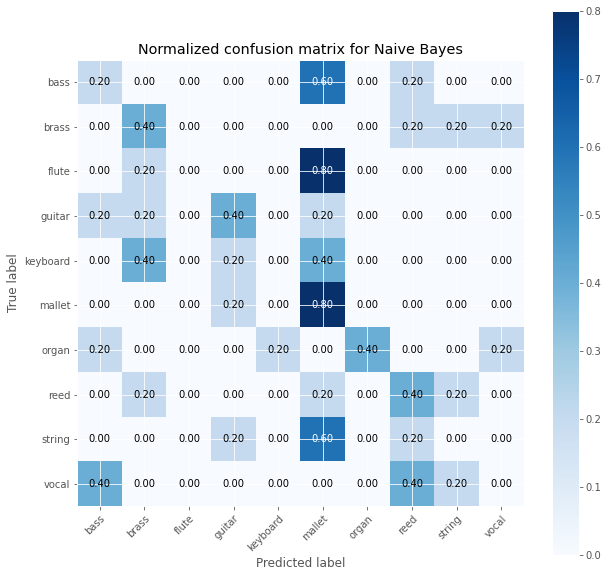

In [17]:
plot_confusion_matrix(y_test, y_pred_NB, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Naive Bayes')

model_save=data_out+'NB'+model_folder
if not os.path.isdir(model_save):
    os.makedirs(model_save)
plt.savefig(model_save+'ConfusionMatrix_normalized.png')

# Random Forests

In [18]:
#instantiate the random forest
clf_Rf =RandomForestClassifier(n_estimators=20, max_depth=50, warm_start=True)

In [19]:
clf_Rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=20, warm_start=True)

In [20]:
y_pred_RF = clf_Rf.predict(X_test)

In [21]:
accuracy_RF = np.mean(y_pred_RF == y_test)
print("The accuracy of Random Forest is {0:.2%}".format(accuracy_RF))
model_save=data_out+'RF'+model_folder
file = open(model_save + "Accuracy.txt","w")
file.write('The accuracy of Random Forest is {0:.2%}'.format(accuracy_RF))
file.close()

The accuracy of Random Forest is 26.00%


Normalized confusion matrix
[[0.4 0.  0.2 0.  0.  0.2 0.2 0.  0.  0. ]
 [0.  0.2 0.  0.  0.2 0.  0.  0.4 0.  0.2]
 [0.2 0.2 0.2 0.  0.  0.  0.  0.4 0.  0. ]
 [0.2 0.2 0.  0.6 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.  0.2 0.  0.  0.2 0.4]
 [0.  0.  0.2 0.6 0.  0.2 0.  0.  0.  0. ]
 [0.2 0.  0.  0.2 0.  0.  0.6 0.  0.  0. ]
 [0.  0.4 0.  0.  0.  0.  0.  0.2 0.2 0.2]
 [0.2 0.  0.  0.  0.  0.4 0.  0.4 0.  0. ]
 [0.4 0.  0.2 0.  0.  0.  0.2 0.  0.  0.2]]


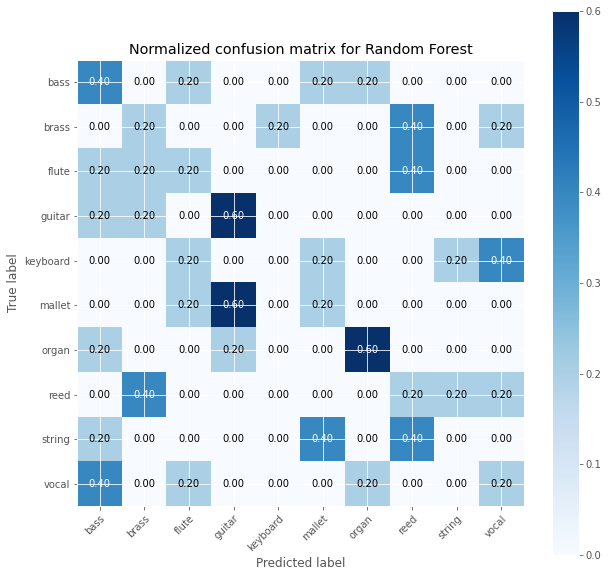

In [22]:
plot_confusion_matrix(y_test, y_pred_RF, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Random Forest')
model_save=data_out+'RF'+model_folder
if not os.path.isdir(model_save):
    os.makedirs(model_save)
plt.savefig(model_save+'ConfusionMatrix_normalized.png')

## Random Search

In [23]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [24]:
param_dist = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [10, 20, 30, 40],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [25]:
#instantiate a new random forest
clf_RF_CV=RandomForestClassifier()

#set number of iterations
n_iter_search = 20
#creat the random search class
random_search_RF = RandomizedSearchCV(clf_RF_CV, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=5)

random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000191E0FEDA60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000191E0FBC4F0>,
                                        'n_estimators': [20, 40, 60, 80]})

In [26]:
y_pred_RF_random = random_search_RF.predict(X_test)
accuracy_RF_random = np.mean(y_pred_RF_random == y_test)
print("The accuracy of Random Forest is {0:.2%}".format(accuracy_RF_random))
model_save=data_out+'RS'+model_folder
file = open(model_save + "Accuracy.txt","w")
file.write('The accuracy of Random Forest (Random Search) is {0:.2%}'.format(accuracy_RF_random))
file.close()

The accuracy of Random Forest is 36.00%


Normalized confusion matrix
[[0.6 0.  0.  0.  0.  0.2 0.  0.  0.  0.2]
 [0.  0.2 0.2 0.  0.  0.  0.  0.2 0.2 0.2]
 [0.2 0.  0.6 0.  0.  0.2 0.  0.  0.  0. ]
 [0.2 0.  0.  0.4 0.  0.2 0.  0.  0.  0.2]
 [0.  0.2 0.2 0.  0.  0.2 0.  0.  0.4 0. ]
 [0.  0.  0.  0.4 0.2 0.4 0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.  0.  0.8 0.  0.  0. ]
 [0.  0.2 0.  0.  0.  0.  0.  0.4 0.  0.4]
 [0.2 0.  0.  0.  0.  0.4 0.  0.2 0.2 0. ]
 [0.6 0.  0.  0.  0.  0.  0.  0.4 0.  0. ]]


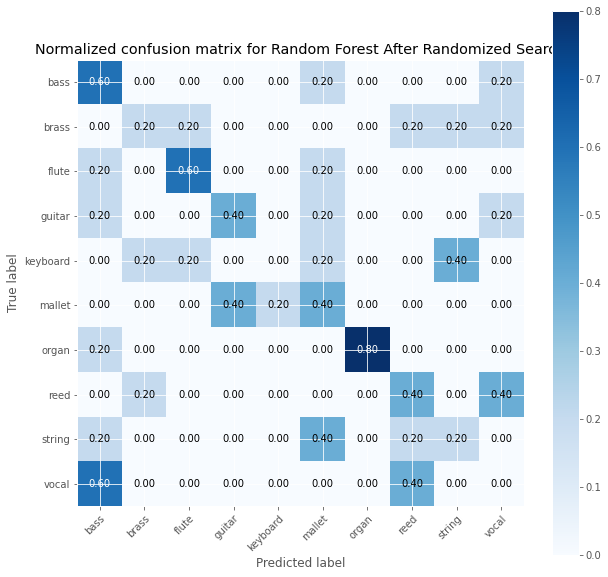

In [27]:
plot_confusion_matrix(y_test, y_pred_RF_random, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Random Forest After Randomized Search')
model_save=data_out+'RS'+model_folder
if not os.path.isdir(model_save):
    os.makedirs(model_save)
plt.savefig(model_save+'ConfusionMatrix_normalized.png')

In [28]:
random_search_RF.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features=10, n_estimators=80)

In [29]:
# pickle the trained model
with open(model_save+"random_search_RF.pickle", mode='wb') as file:
    pickle.dump(random_search_RF, file)

# Support Vector Machine (SVM)

In [30]:
#instantiate the scaler
scaler = MinMaxScaler()

In [31]:
#scale the feature space
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [32]:
#instatiate the  classifier
clf_svm = SVC(C=0.1)

In [33]:
clf_svm.fit(X_train_scale, y_train)

SVC(C=0.1)

In [34]:
y_pred_svm = clf_svm.predict(X_test_scale)
accuracy_svm = np.mean(y_pred_svm == y_test)
print("The accuracy of SVMs is {0:.2%}".format(accuracy_svm))
model_save=data_out+'SVM'+model_folder
file = open(model_save + "Accuracy.txt","w")
file.write('The accuracy of SVMs is {0:.2%}'.format(accuracy_svm))
file.close()

The accuracy of SVMs is 26.00%


In [35]:
#display non normalized confusion matrix
confusion_matrix(y_test, y_pred_svm)

array([[0, 0, 0, 1, 0, 1, 1, 0, 0, 2],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 2],
       [0, 1, 0, 1, 3, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 2, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 4]], dtype=int64)

Normalized confusion matrix
[[0.  0.  0.  0.2 0.  0.2 0.2 0.  0.  0.4]
 [0.  0.2 0.2 0.  0.2 0.  0.  0.  0.  0.4]
 [0.  0.2 0.2 0.  0.  0.2 0.  0.  0.  0.4]
 [0.  0.2 0.  0.2 0.6 0.  0.  0.  0.  0. ]
 [0.  0.4 0.  0.2 0.2 0.2 0.  0.  0.  0. ]
 [0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.2]
 [0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.2]
 [0.  0.2 0.2 0.  0.2 0.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.4 0.2 0.  0.2 0.  0.2]
 [0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.8]]


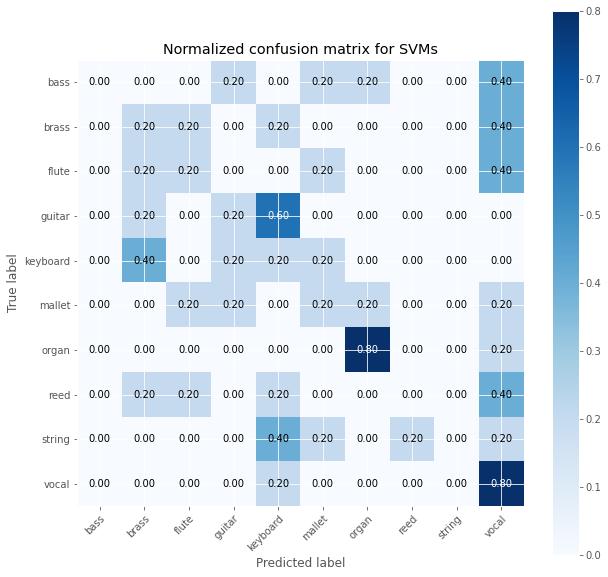

In [36]:
plot_confusion_matrix(y_test, y_pred_svm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for SVMs')
model_save=data_out+'SVM'+model_folder
if not os.path.isdir(model_save):
    os.makedirs(model_save)
plt.savefig(model_save+'ConfusionMatrix_normalized.png')

# k-Nearest Neighbors (k-NN)

In [37]:
#instantiate the scaler
scaler = MinMaxScaler()

In [38]:
#scale the feature space
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [43]:
#instatiate the  classifier
knn = KNeighborsClassifier(n_neighbors=9)

In [44]:
knn.fit(X_train_scale, y_train)

KNeighborsClassifier(n_neighbors=9)

In [46]:
y_pred_knn = knn.predict(X_test_scale)
accuracy_knn = np.mean(y_pred_knn == y_test)
print("The accuracy of k-NN is {0:.2%}".format(accuracy_knn))
model_save=data_out+'KNN'+model_folder
file = open(model_save + "Accuracy.txt","w")
file.write('The accuracy of k-NN is {0:.2%}'.format(accuracy_knn))
file.close()

The accuracy of k-NN is 16.00%


In [47]:
#display non normalized confusion matrix
confusion_matrix(y_test, y_pred_knn)

array([[0, 0, 0, 1, 0, 1, 1, 0, 0, 2],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 2],
       [0, 1, 0, 1, 3, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 2, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 4]], dtype=int64)

Normalized confusion matrix
[[0.  0.  0.  0.2 0.  0.2 0.2 0.  0.  0.4]
 [0.  0.2 0.2 0.  0.2 0.  0.  0.  0.  0.4]
 [0.  0.2 0.2 0.  0.  0.2 0.  0.  0.  0.4]
 [0.  0.2 0.  0.2 0.6 0.  0.  0.  0.  0. ]
 [0.  0.4 0.  0.2 0.2 0.2 0.  0.  0.  0. ]
 [0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.2]
 [0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.2]
 [0.  0.2 0.2 0.  0.2 0.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.4 0.2 0.  0.2 0.  0.2]
 [0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.8]]


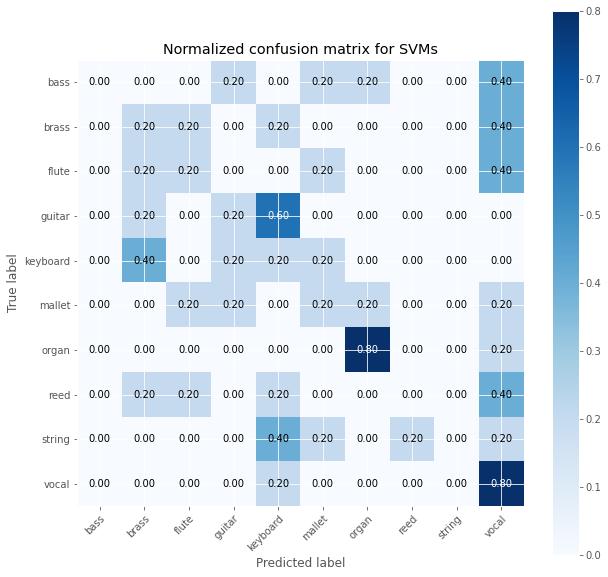

In [48]:
plot_confusion_matrix(y_test, y_pred_knn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for k-NN')
if not os.path.isdir(model_save):
    os.makedirs(model_save)
plt.savefig(model_save+'ConfusionMatrix_normalized.png')